<a href="https://colab.research.google.com/github/Mvoii/myspotify-analysis/blob/main/taste_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
filename = "musicthatgigglesmybooty.csv"

from matplotlib import pyplot
import seaborn
import pandas as pd
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

# read the data
data = pd.read_csv(filename)
# data.drop("Unnamed: 0", axis=1, inplace=True)
print("total songs:", data.shape[0])
print(data[:3])

total songs: 2488
               Spotify ID                                     Artist IDs  \
0  36wx7z7hXQ11EhYtfgEgM0                         6BEwwGiWuXadRmIfQU9NSt   
1  6bU9aYY97cCrzsx1IKdxZG  27mWOSZjlpmtoqsRjRwQyu,58vAPzbpMZAVTHWA1KT68B   
2  6gbcV35Fx1UG74mqXYCloC  7ejF235eYuh8PlQDLaJy0N,3JX3pY7okkEyFnbtuELshV   

     Track Name  Album Name        Artist Name(s) Release Date  Duration (ms)  \
0           Sky         Sky              M.E.M.O.   2022-08-26         224591   
1  What U Doing       Roots  Dennis Cruz,Leo Wood   2021-10-29         229523   
2    All I Know  All I Know        PARIS,Pantheon   2022-02-11         314913   

   Popularity                                Added By              Added At  \
0          35  spotify:user:9hjs0wc0ej2iyigebuugtjwwk  2023-11-21T11:02:23Z   
1          47  spotify:user:9hjs0wc0ej2iyigebuugtjwwk  2023-11-21T11:02:23Z   
2          29  spotify:user:9hjs0wc0ej2iyigebuugtjwwk  2023-11-21T11:02:23Z   

   ...   Key  Loudness  Mode  Speec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.columns

# data = data.dropna('Artist Name(s)', inplace=True)
# count the nan values
count_nan = data['Artist Name(s)'].isnull().sum()
print("nan values: " + str(count_nan))

data = data.dropna().reset_index(drop=True)

count_nan = data["Artist Name(s)"].isnull().sum()
print("nan values: " + str(count_nan))

nan values: 2
nan values: 0


number of unique artist: 1650


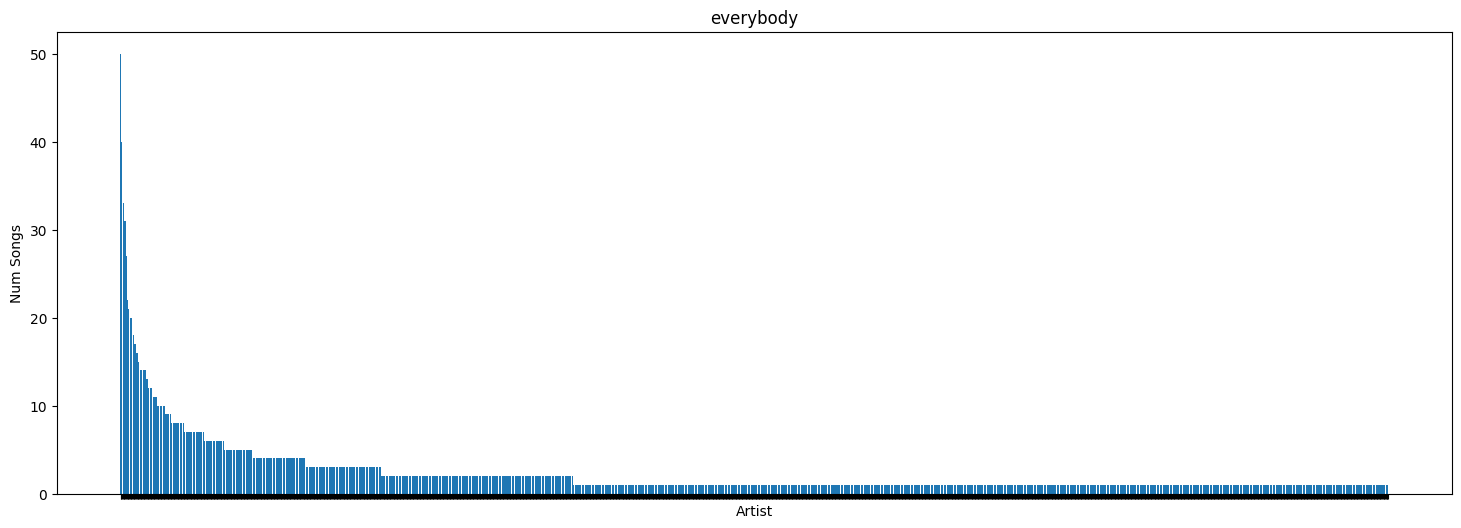

In [ ]:
# count songs per artist
# data = data.fillna()
artists = defaultdict(int)
for i, song in data.iterrows():
    artist_names = song['Artist Name(s)']

    #adding debug print statements
    # print(f"processing {i}, artist name: {artist_names}")

    #for musician in artist_names.split(","):
        #cleaned_musician = musician.strip()

        # debug
        # print(f"found artist: {artist_names}")

        # artists[cleaned_musician] += 1
    for musician in song['Artist Name(s)'].split(','):
        artists[musician] += 1
        # print(f"found artist: {artist_names}")

# sort for chart
artists = pd.DataFrame(artists.items(), columns=['Artist', 'Num Songs']
                          ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique artist:", artists.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists["Artist"], artists["Num Songs"])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("everybody")
pyplot.show()

Note I've attributed songs with multiple artists to multiple bars, so the integral here is the number of unique song-artist pairs, not just the number of songs.

It seems to follow a Pareto distribution. Let's try to fit one

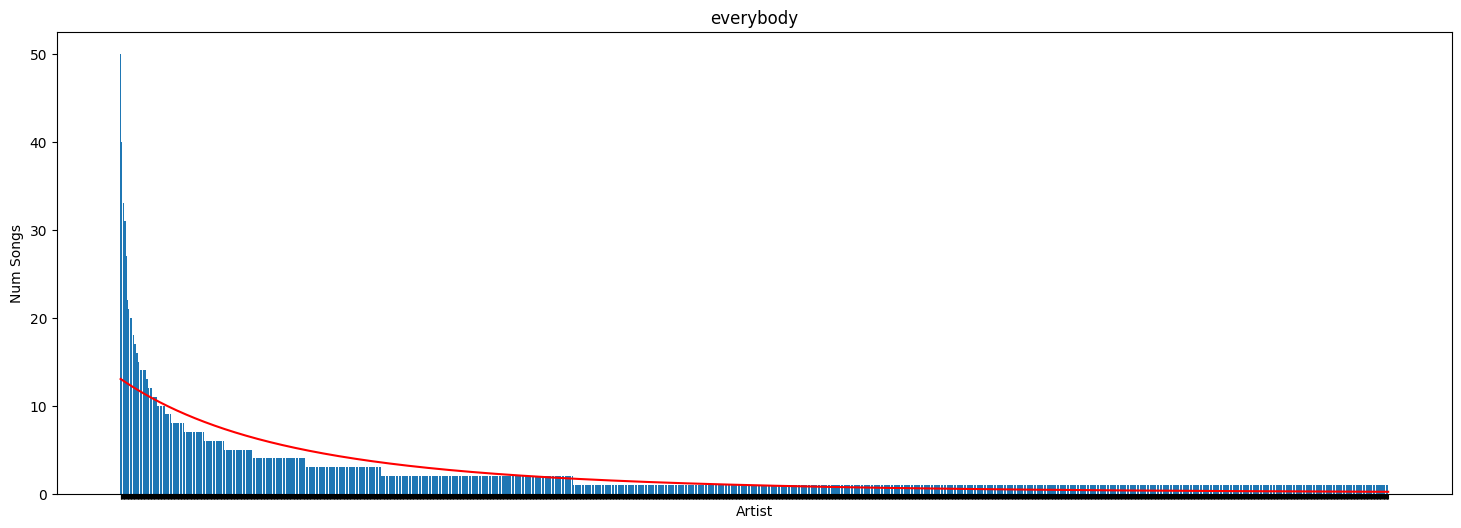

In [ ]:
# Lets find teh best p[arameters. Need x, y data 'sampled'
# from the distribution for parameter fit

y = []
for i in range(artists.shape[0]):
    for j in range(artists["Num Songs"][i]):
        y.append(i) # just let y have index[artist] repeated
                    # for each song

# sanity check, if dataframe is not sorted properly, y isn't either
# pyplot.figure()
# pyplot.hist(y, bins=30)

# the documentaion ie bad but this is okay:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-
# ones-with-scipy-python
param = pareto.fit(y, 100)
pareto_fitted = len(y) * pareto.pdf(range(artists.shape[0]), *param)
# param = gamma.fit(y) # gamma fits abysmally; see for yourself
# gamma_unfitted = len(y)*gamma.pdf(range(artists.shape[0], *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists["Artist"], artists["Num Songs"])
pyplot.plot(pareto_fitted, color='r')
# pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("everybody");



Best fit is still too sharp for the data, and I tried for a good long while to get it to fit better, so I conclude this doesn't quite fit a power law.

Let's plot the top 50 artists so we can actually read who they are.


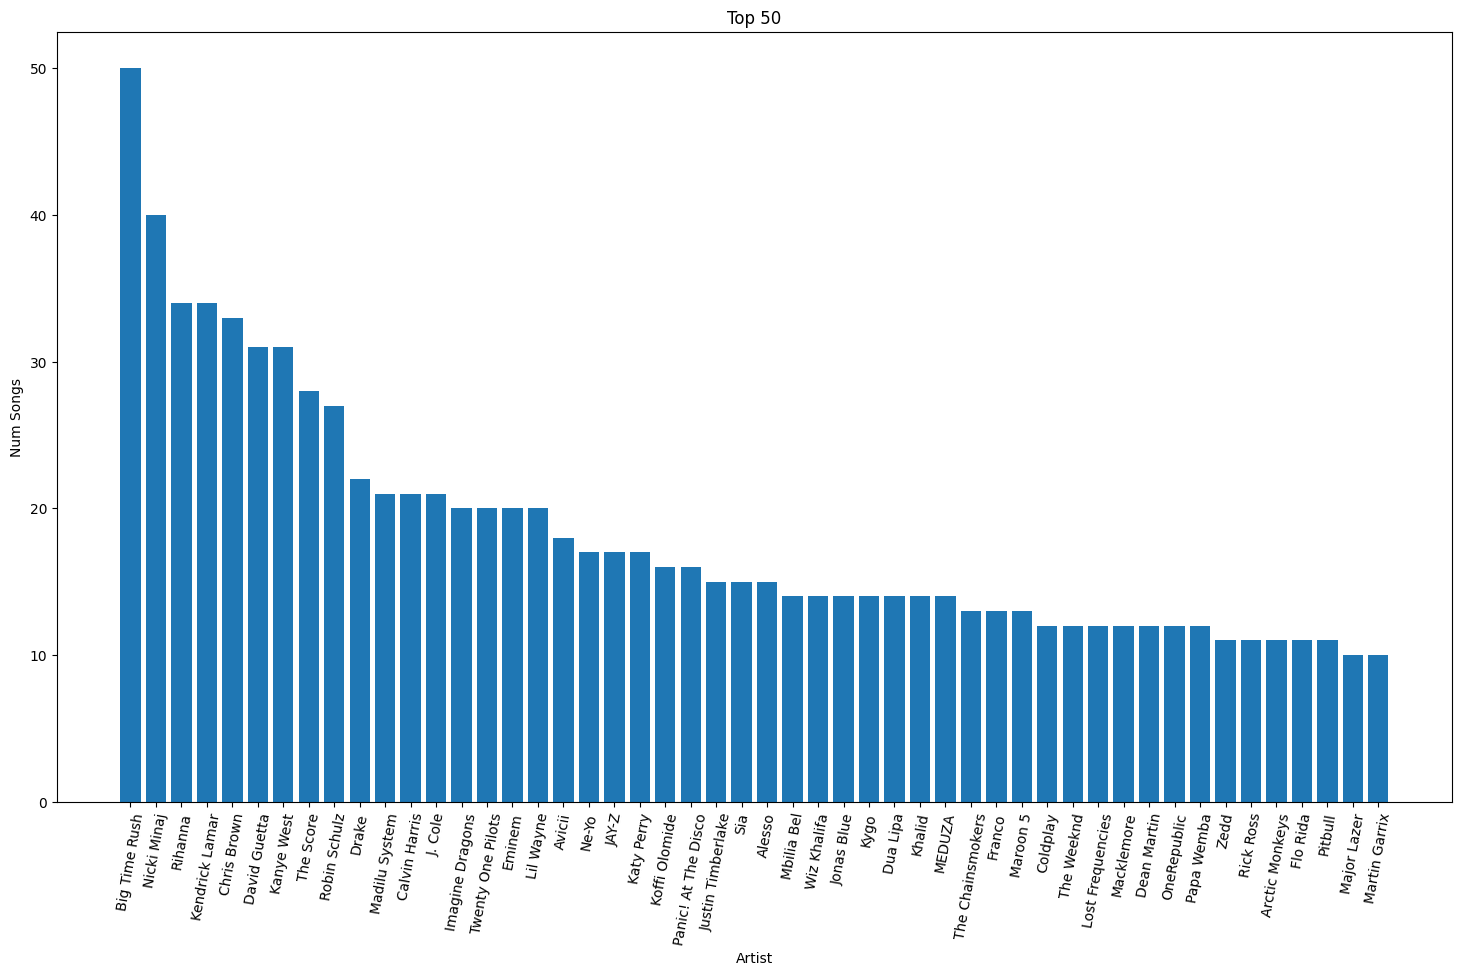

In [ ]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(artists["Artist"][:50], artists["Num Songs"][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("Top 50");

<h3>Volume Added Over Time</h3>
My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

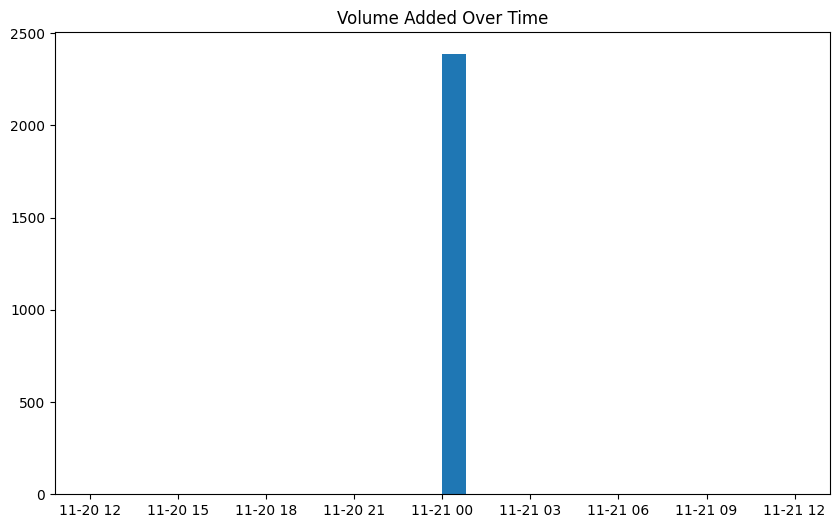

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # to suppress the warnings

# Plot of added volume over time
parse_date =  lambda d:(int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(figsize = (10, 6))
pyplot.hist([date(*parse_date(d)) for d in data["Added At"]], bins=30)
pyplot.title("Volume Added Over Time");



The initial spike is from when I first stared using Spotify as the home for this collection and manually added hundreds from my previous list.

That is what I would have said if this was the original liked songs playlists and not the playlist that is a copy of liked songs... A playlist I created this afternoon.

<h3>Eclecticness Measure (Frequency Transform)</h3>

This one is a personal favorite. I want to know how many of my songs are one-offs from that artist for me--just individual pieces I found fantastic and ended up adding after a few listens--, how many are two-offs, et cetera. I know it must be heavily skewed toward the low numbers.

number of song-artists pairs represented in the eclecticness chart: 3857


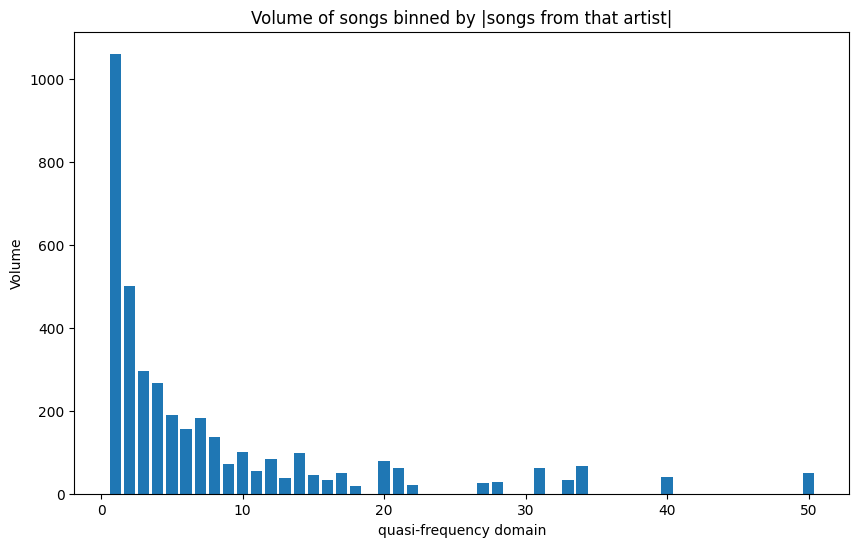

In [ ]:
# bar chart of first bar chart == hipster diversity factor
frequency = defaultdict(int)
for n in artists["Num Songs"]:
    frequency[n] += n
frequency = pd.DataFrame(frequency.items(), columns=["Unique Count", "Volume"]
                           ).sort_values("Volume", ascending=False)
print("number of song-artists pairs represented in the eclecticness chart:",
      sum(frequency["Volume"]))

pyplot.figure(figsize=(10, 6))
pyplot.bar(frequency["Unique Count"].values, frequency["Volume"].values)
pyplot.title("Volume of songs binned by |songs from that artist|")
pyplot.xlabel("quasi-frequency domain")
pyplot.ylabel(frequency.columns[1]);



So, yes, it's much more common for an artist to make it in my list a few times than many times. In fact, the plurality of my top songs come from unique artists.

Conversely, this view also makes stark those few musicians from whom I've collected dozens.

Note that here, as in the artist bar charts, some songs are doubly-counted, because in cases artists collaborated I listed the song in both bins.

<h3>Genres Bar Chart</h3>

Alright, enough messing around. All the above were possible with the output from Watsonbox's Exportify. Let's get to the novel stuff you came here for.

People describe music by genre. As we'll see, genre names are flippin' hilarious and extremely varied, but in theory if I cluster around a few, that should give you a flavor of my tastes.</h3>

Number of unique genres: 712


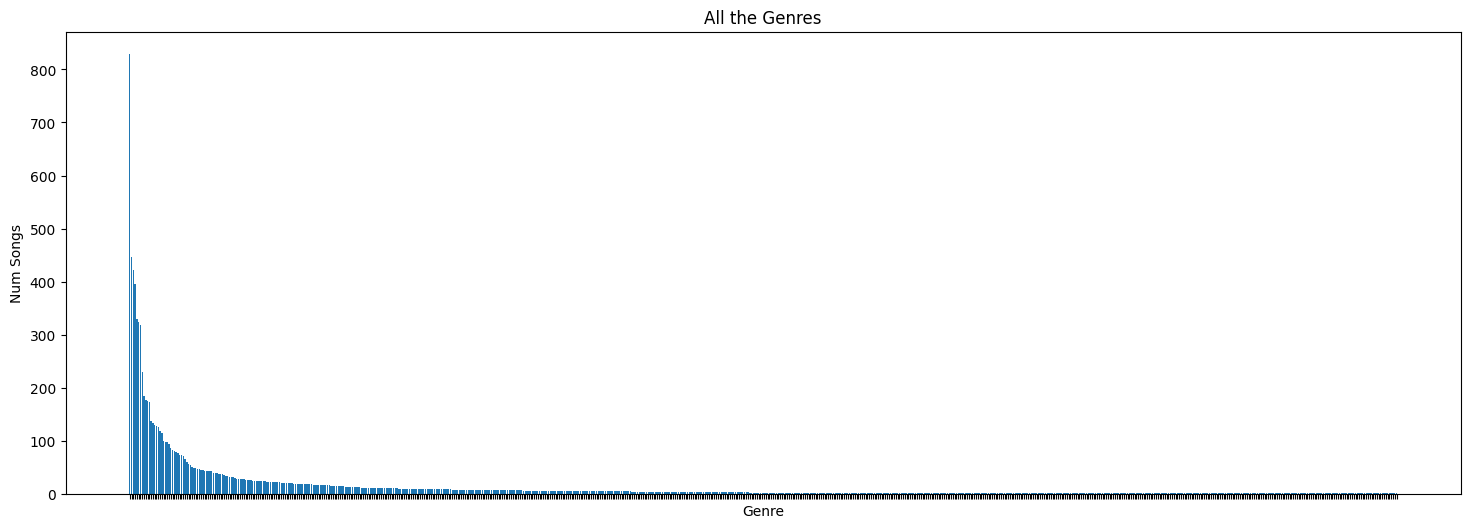

In [ ]:
# count songs per genre
genres = defaultdict(int)
for i, song in data.iterrows():
    if type(song["Genres"]) is str: # sometimes they aren't any, and this is NaN
        for genre in song["Genres"].split(","):
            if len(genre) > 0: # empty str seems to be legit genre
                genres[genre] += 1

# sort for the chart
genres = pd.DataFrame(genres.items(), columns=["Genre", "Num Songs"]
                         ).sort_values("Num Songs", ascending=False).reset_index(drop=True)
print("Number of unique genres:", genres.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres['Genre'], genres["Num Songs"])
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("All the Genres");

so many! Lets do the same thing as we did with artists and for giggles see if it fits a powerlaw

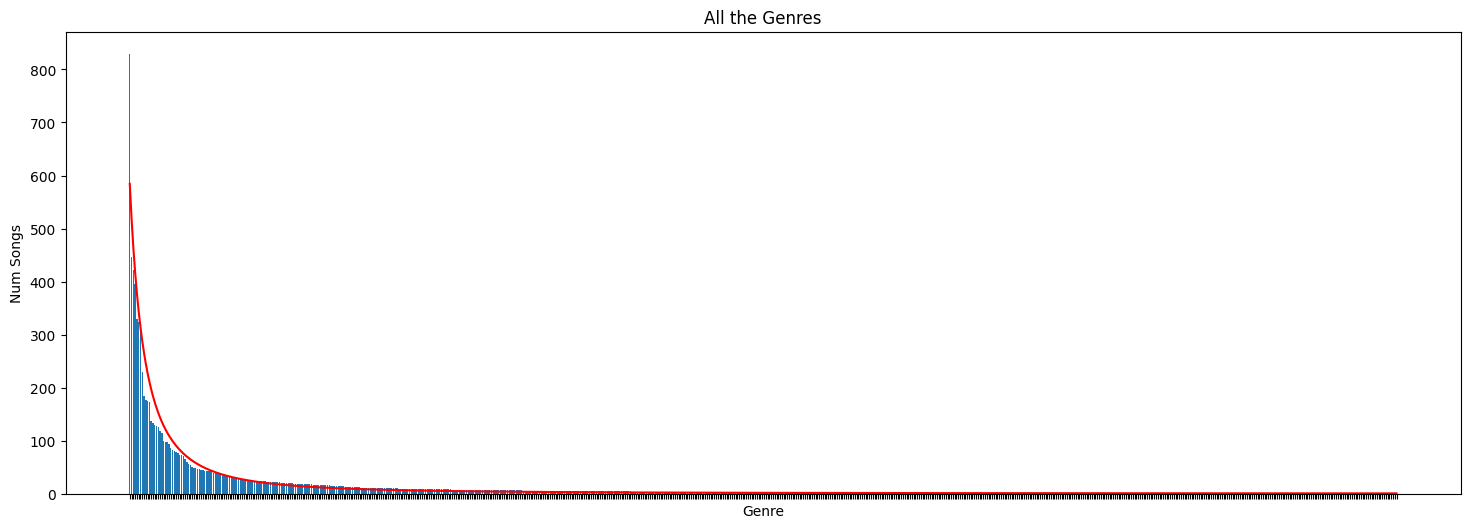

In [ ]:
y = []
for i in range (genres.shape[0]):
    for j in range(genres["Num Songs"][i]):
        y.append(i)

# sanity check
# pyplot.figure()
# pyplot.hist(y, bins=30)

param = pareto.fit(y, 100)
pareto_fitted = len(y)*pareto.pdf(range(genres.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres["Genre"], genres["Num Songs"])
pyplot.plot(pareto_fitted, color='r')
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("All the Genres");



Still too sharp, but fits better than with the artists.

Let's look at the top 50 so we can read the names.


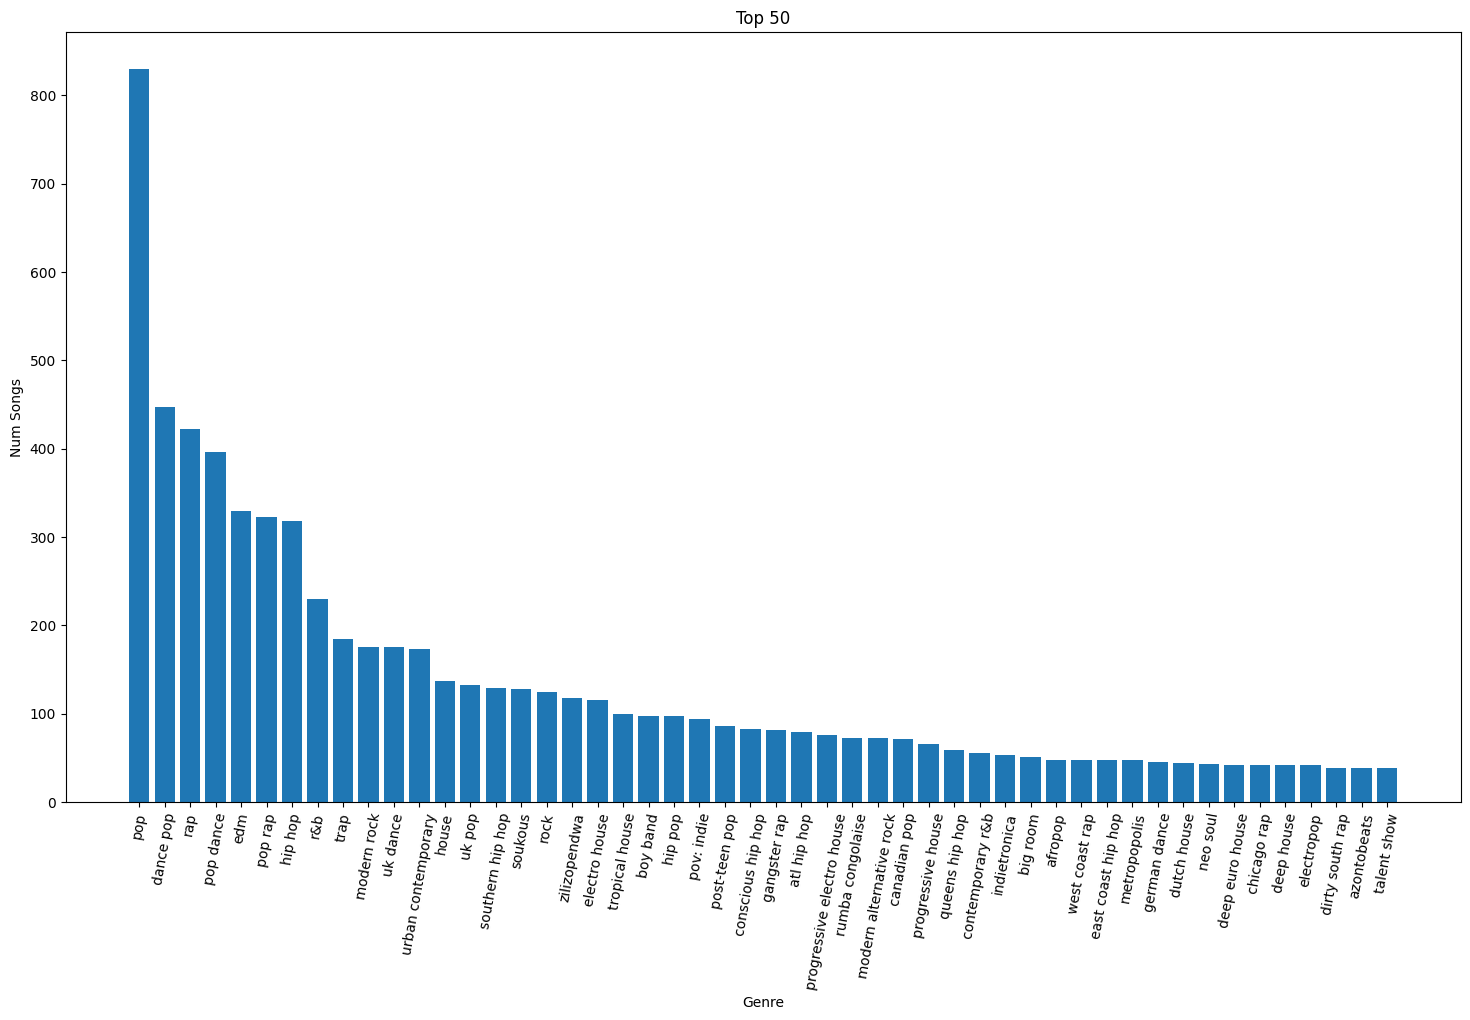

In [ ]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(genres["Genre"][:50], genres["Num Songs"][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Top 50");



"Talent show" lol. wtf? "Big Room", "pov:indie", "soukous", "Tropical House", "Electro-House", "Indietronica", "Neo Soul", "Mellow gold"

These are too good. Next time someone asks me my music taste, I'm definitely using these.

If these are the most popular names, what are the really unique ones at the bottom of the chart?


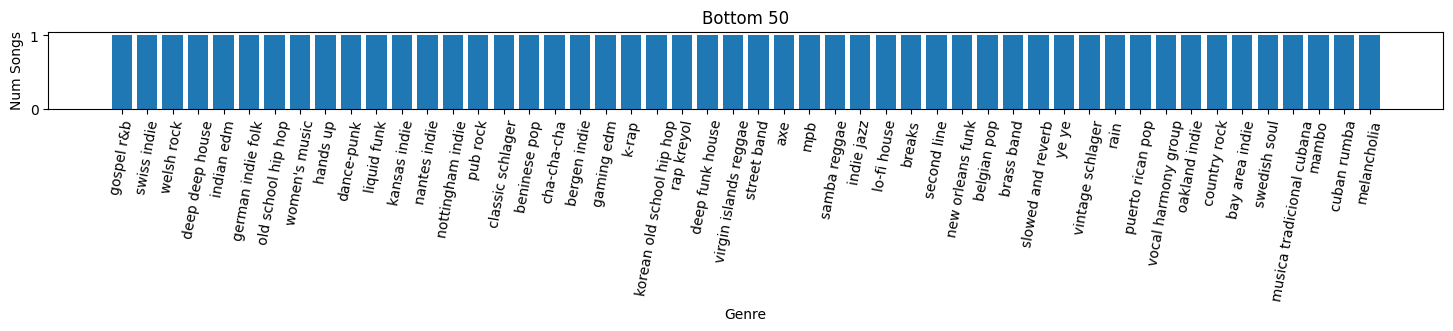

In [ ]:
pyplot.figure(figsize=(18, 1))
pyplot.bar(genres["Genre"][-50:], genres["Num Songs"][-50:])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Bottom 50");



"Hauntology", "Deep Deep House", "Musica Tradicional Cubana Mambo", "Indie Jazz", "Second Line", "Shamanic", "Deep Underground Hip Hop", "Women's Music"?

That was fun.

<h3>Release Dates</h3>

Which era of music do I prefer?

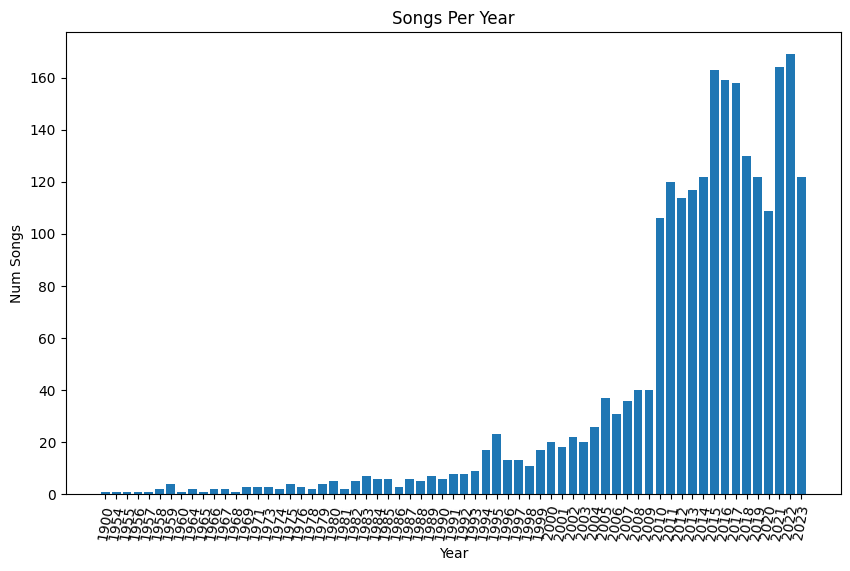

In [ ]:
years = defaultdict(int)
for i, song in data.iterrows():
    years[song["Release Date"][:4]] += 1

years = pd.DataFrame(years.items(), columns=["Year", "Num Songs"]
                        ).sort_values("Year")

pyplot.figure(figsize=(10, 6))
pyplot.bar(years["Year"], years["Num Songs"])
pyplot.xticks(rotation=80)
pyplot.xlabel(years.columns[0])
pyplot.ylabel(years.columns[1])
pyplot.title("Songs Per Year");



It seems to follow a Gamma distribution! This makes sense because I'm more likely to have heard things that are nearer me in time, and it takes a while for them to get through my process and become favorites.

Let's fit that gamma to the time-reversed data.


In [ ]:
# Some years are missing, so transform to a dataframe that covers full time perios
#eldest = int(years["Year"].values[0])
#youngest = int(years["Year"].values[-1])
#missing_years = [str(x) for x in range(eldest+1, youngest) if
#                 str(x) not in years["Year"].values]
#ago = years._append(pandas.DataFrame.from_dic(
#    {"Year": missing_years, "Num Songs": [0 for x in range(len(missing_years))]})
#                  ).sort_values("Year", ascending=False).reset_index(drop=True)
#y = []
#for i in range(ago.shape[0]):
#    for j in range(int(ago["Num Songs"][i])):
 #       y.append(i)

# sanity check histogram to make sure I'm constructing properly
# pyplot.figure()
# pyplot.hist(y, bin=30)

#param = gamma.fit(y, 10000)
#gamma_fitted = len(y)*gamma.pdf(range(ago.shape[0]), *param)

#pyplot.figure(figsiize=(10, 6))
#pyplot.bar(range(len(ago["Year"])), ago["Num Songs"])
#pyplot.plot(gamma_fitted, color='g')
#pyplot.xlabel("Years Ago")
#pyplot.ylabel(ago.columns[1])
#pyplot.title("Songs Per Year (In Absolute Time)");

print("Oldest Hall of Fame")
print(data[["Track Name", "Artist Name(s)", "Release Date"]].sort_values(
    "Release Date")[:10])


Oldest Hall of Fame
                                             Track Name      Artist Name(s)  \
1642                                         One by One  Laza Morgan,Mavado   
1190                                     Mambo Italiano         Dean Martin   
227                                      Let's Get Lost          Chet Baker   
195                                        C'est Si Bon         Eartha Kitt   
718                           Hallelujah, I Love Her So         Ray Charles   
1192  Volare (Nel Blu Di Pinto Di Blu) - Remastered ...         Dean Martin   
423     Write To Me From Naples - 1998 Digital Remaster         Dean Martin   
1185                                     Mack the Knife         Bobby Darin   
809                        What A Diff'rence A Day Made    Dinah Washington   
397                                      You're The Top       Jeri Southern   

     Release Date  
1642   1900-01-01  
1190         1954  
227    1955-01-01  
195          1956  
718    195

Pretty good fit! I seem to be extra partial to music from about 5 years ago.
Crazy! Dean Martin 1954?? The 50's had great music!
We'll see whether the present or maybe the further past catches up.

<h3>Popularity Contest</h3>

I was happy to find popularity listed as a field in Spotify's track JSON. It's a percentile between 0 and 100, rather than an absolute number of plays. Still, it can be used to give a notion of how hipster I am.

Average song popularity:  48.04123711340206
Median song popularity:  48.0
Max song popularity:  97


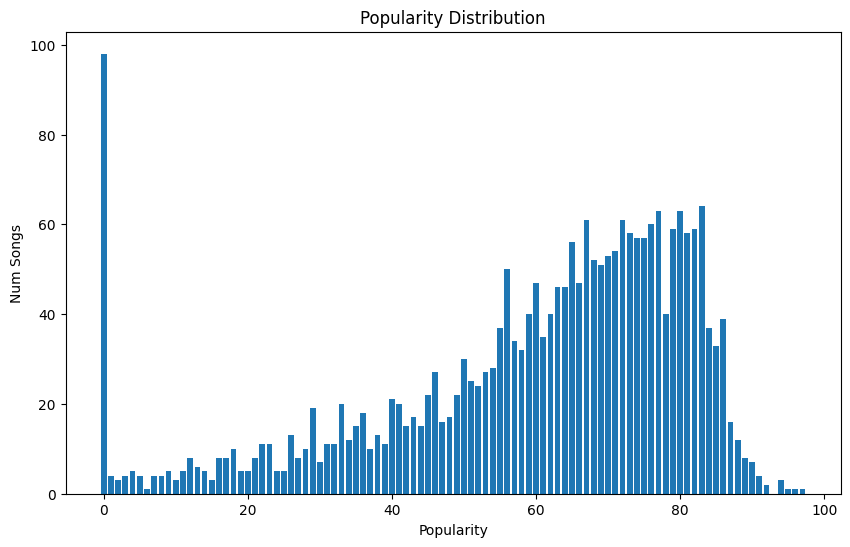

In [ ]:
popularity = defaultdict(int)
for i, song in data.iterrows():
    # print(song[["Popularity"]])
    popularity[song['Popularity']] += 1

popularity = pd.DataFrame(popularity.items(), columns=["Popularity", "Num Songs"]
                             ).sort_values("Popularity")

pyplot.figure(figsize=(10, 6))
pyplot.bar(popularity["Popularity"].values, popularity["Num Songs"].values)
pyplot.xlabel(popularity.columns[0])
pyplot.ylabel(popularity.columns[1])
pyplot.title("Popularity Distribution");

print("Average song popularity: ", popularity["Popularity"].mean())
print("Median song popularity: ", popularity["Popularity"].median())
print("Max song popularity: ", popularity["Popularity"].max())

Damn, I'm a hipster

<h3>Track Duration</h3>

Do I prefer long songs or short ones?

Average song lengths: 3:56.29670452640403
Median song lengths: 3:35.682500000000005


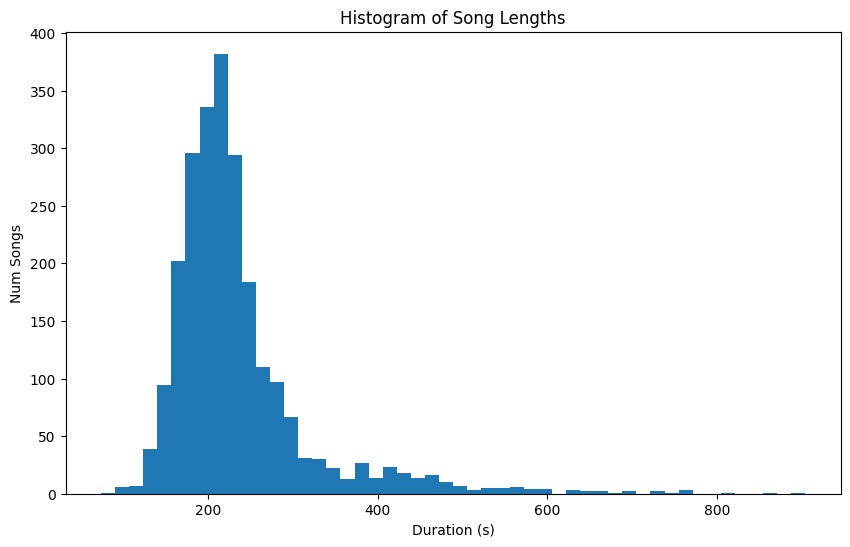

In [ ]:
pyplot.figure(figsize=(10, 6))
pyplot.hist(data["Duration (ms)"]/1000, bins=50);
pyplot.xlabel("Duration (s)")
pyplot.ylabel("Num Songs")
pyplot.title("Histogram of Song Lengths")

mean = data["Duration (ms)"].mean()/1000
median = data["Duration (ms)"].median()/1000
print("Average song lengths: " + str(int(mean//60)) + (":" if mean%60 >= 10 else ":0")
      + str(mean%60))
print("Median song lengths: " + str(int(median//60)) + (":" if median%60 >= 10 else ":0")
      + str(median%60))

Median is lower than mean, so I'm right skewed. That is, I like more short songs than longer songs. What are the songs?

In [ ]:
print("Longest Hall of Fame: ")
print(data[["Track Name", "Artist Name(s)", "Release Date", "Duration (ms)"]
      ].sort_values("Duration (ms)", ascending=False)[:10])

Longest Hall of Fame: 
                                   Track Name                 Artist Name(s)  \
2089                        Franco de mi amor                  Madilu System   
2046                         Mario (Non stop)               Franco,TPOK Jazz   
2009                       Attetion Na Sida I                         Franco   
2033  Bele:Ebale/Ya Zaïre/Faute Ya Commerçant         Simaro Massiya Lutumba   
2024                          Dede sur mesure              Zaïko Langa Langa   
1054                              Tres Impoli                         Franco   
5               Oxygen - Klangkarussell Remix             SIN,Klangkarussell   
2006                     Fabrice akende sango  Franco,TPOK Jazz,Sam Mangwana   
2183       Sing About Me, I'm Dying Of Thirst                 Kendrick Lamar   
1985                                      Sai                Kanda Bongo Man   

     Release Date  Duration (ms)  
2089   2010-01-01         903800  
2046   1989-01-01         

Obviously Rhumba was the longest ones. I LOVE MADILU!
Sorry for that outburst.
Now on to the next one.


<h3>Musical Features</h3>

In the interest of understanding user tastes and providing the best possible music recommendations, Spotify has done some really sophisticated analysis of actual track content. Music is a time series, but most similarity metrics (and most ML methods generally) require inputs to be vectors, that is: points in some feature-space. So they've transformed the tracks to numerical metrics like Energy and Valence (continuous) and Key (discrete).

For the continuous metrics, they provide distributions across all music. Here they are next to similar plots of my own songs.


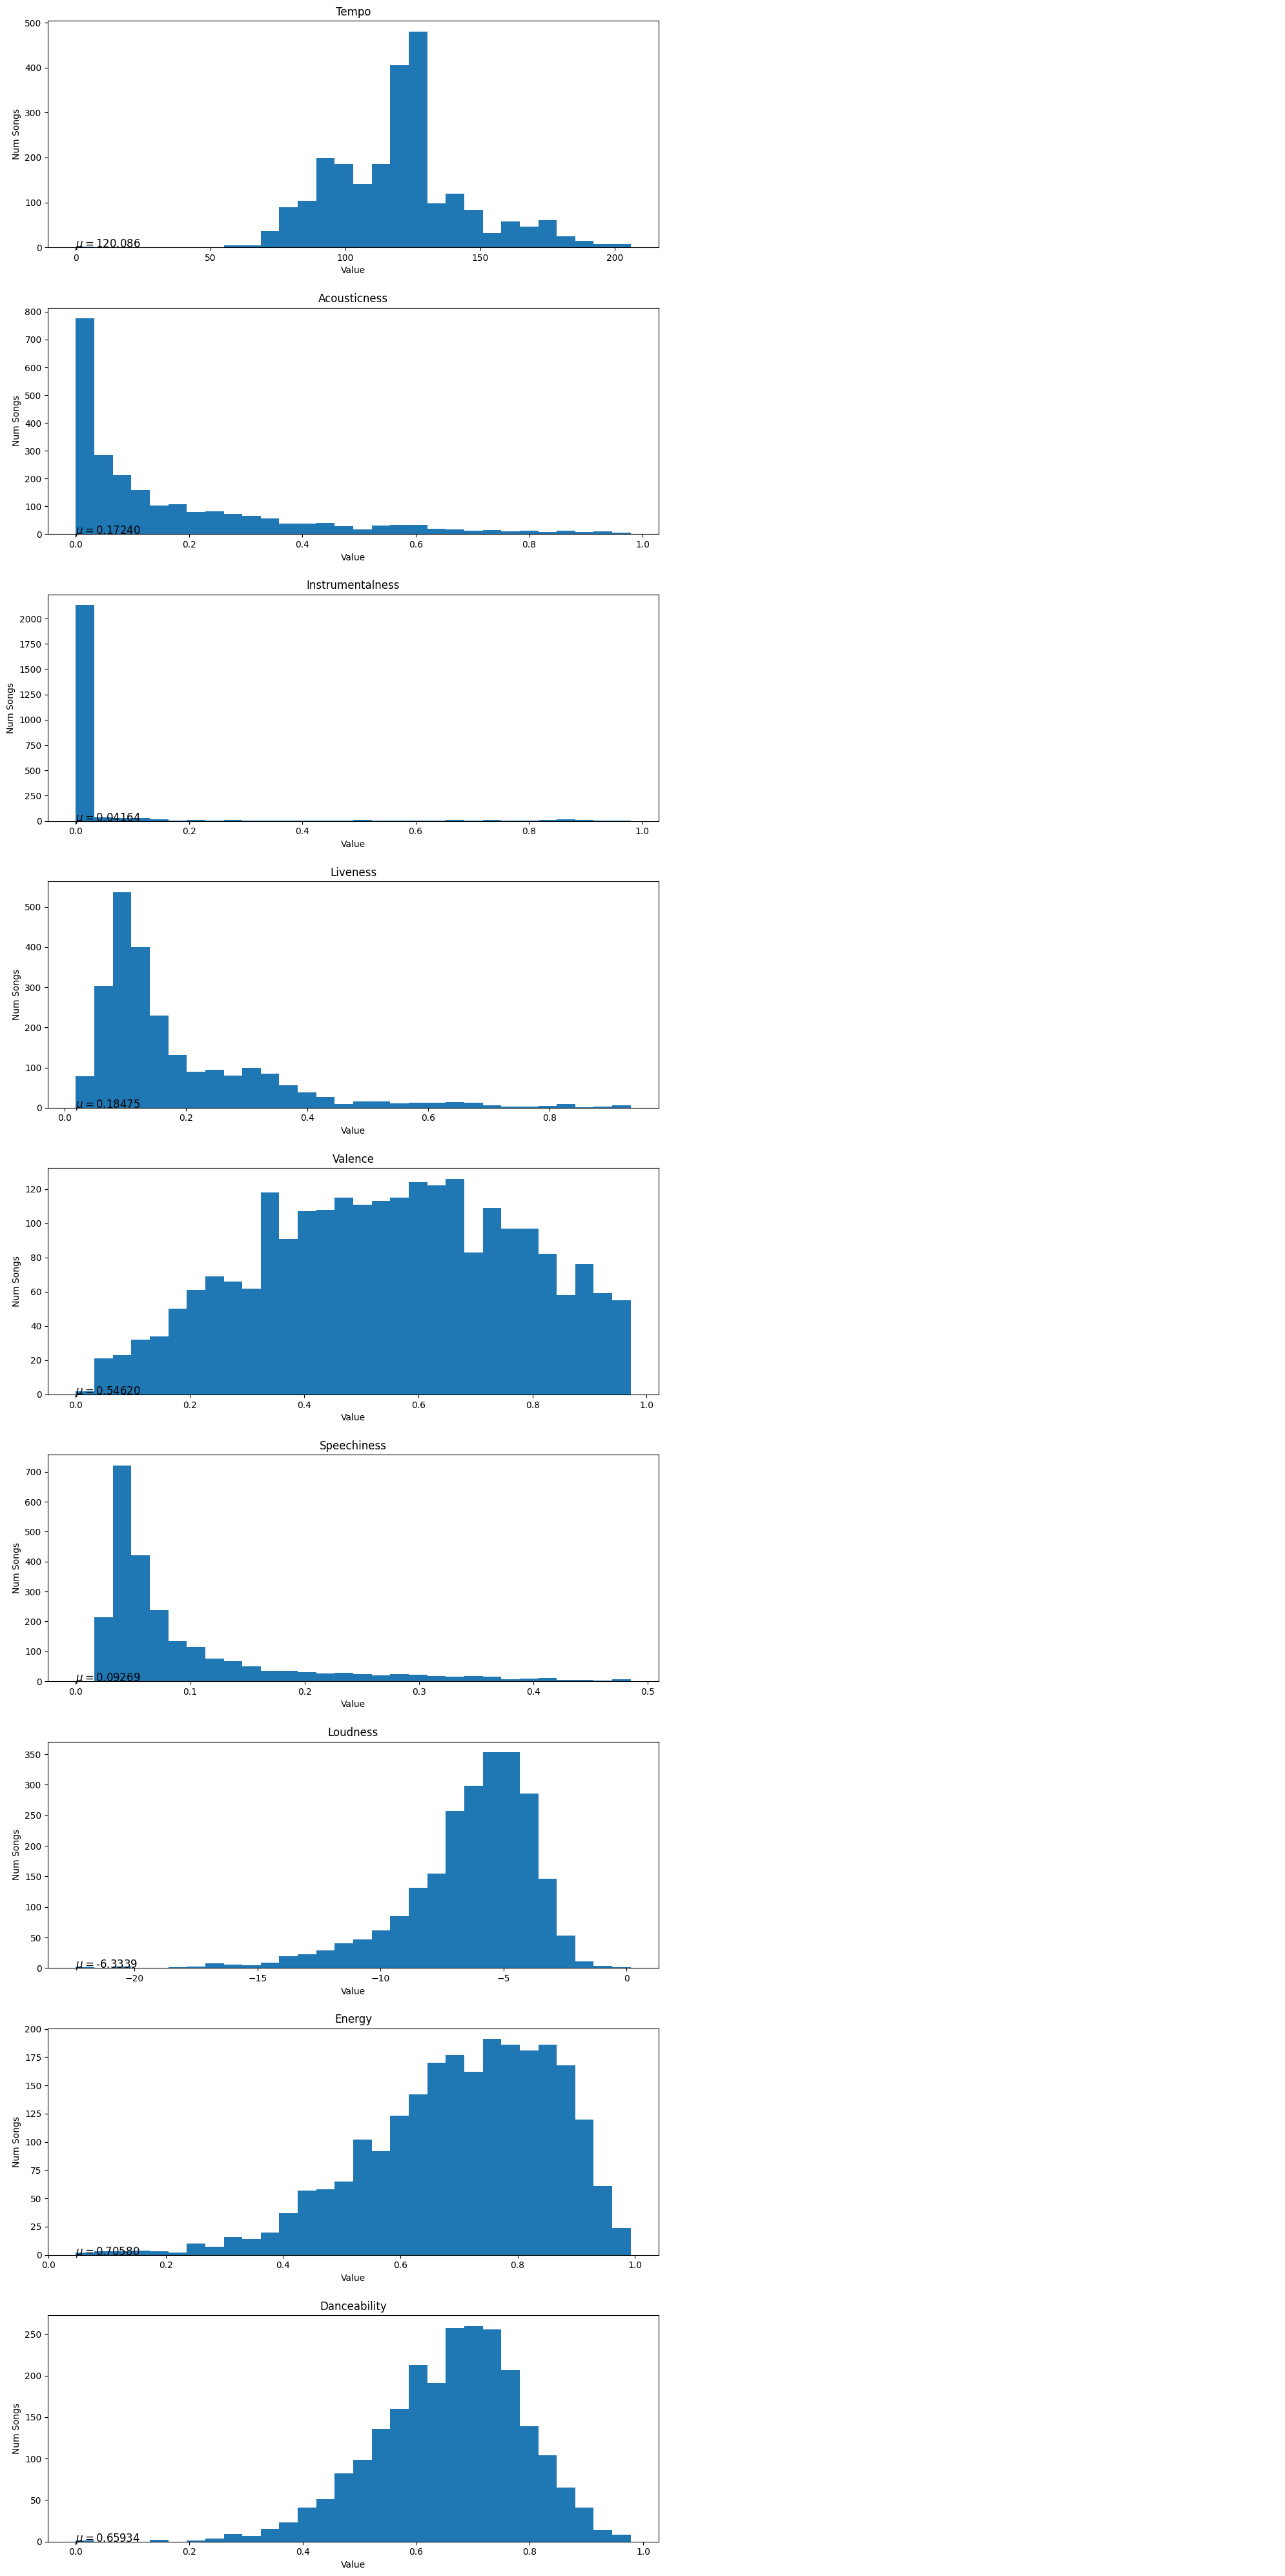

In [ ]:
pyplot.figure(figsize=(20, 40))

for i, category in enumerate(["Tempo", "Acousticness", "Instrumentalness", "Liveness",
                              "Valence", "Speechiness", "Loudness", "Energy", "Danceability"]):
    pyplot.subplot(9, 2, i*2+1)
    # it will be a nice show the KDE on these plots, but there isn't a way
    # to show it on unnormalized https://github.com/mwaskom/seaborn/issues/479
    pyplot.hist(data[category], bins=30)
    pyplot.text(min(data[category]), 0, r'$\mu=$'+str(data[category].mean())[:7], fontsize=12)
    pyplot.xlabel("Value")
    pyplot.ylabel("Num Songs")
    pyplot.title(category)

    pyplot.subplot(9, 2, i*2+2)
    # pyplot.imshow(pyplot.imread("https://developer.spotify.com/assets/audio/"+category.lower()+".png"))
    pyplot.axis("off")

pyplot.tight_layout(h_pad=2)



Looks like my preferred Tempo, Energy, Danceability and Loudness are high. Energy is pretty similar, but I have perhaps slightly lower affinity for the low-energetic stuff. My Valence is somewhat positively skewed, meaning I like energetic songs than average. And my Speechiness peaks lower than average illustrating my love for beats.

Now let's look at the discrete music features.


<ipython-input-32-1590827fa6de>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=45, ha="right")
<ipython-input-32-1590827fa6de>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(["minor", "major"], rotation=45)


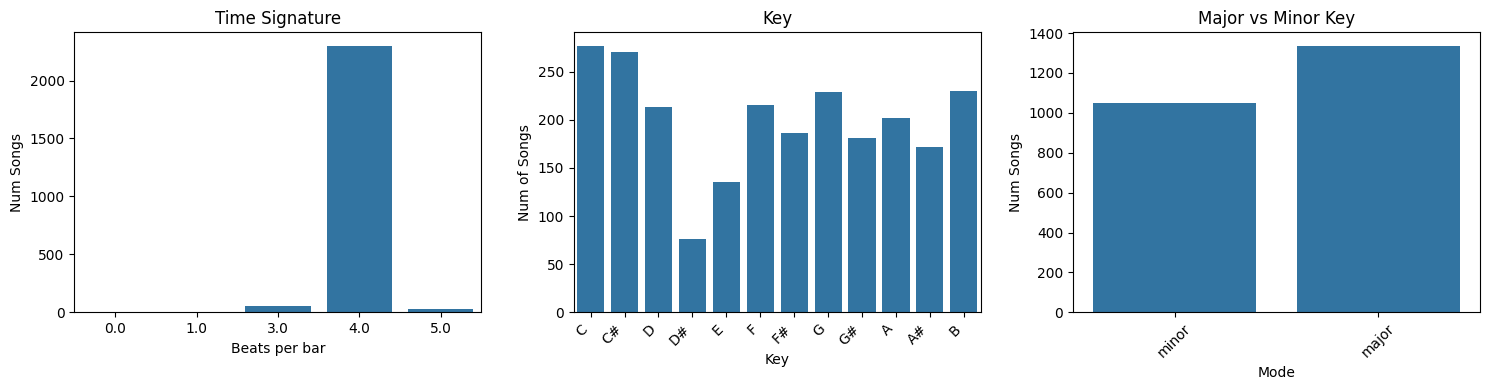

In [ ]:
pyplot.figure(figsize=(15, 4))

pyplot.subplot(1, 3, 1)
seaborn.countplot(data=data, x=data["Time Signature"])
pyplot.xlabel("Beats per bar")
pyplot.ylabel("Num Songs")
pyplot.title("Time Signature")

pyplot.subplot(1, 3, 2)
axes = seaborn.countplot(data=data, x=data["Key"])
axes.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=45, ha="right")
pyplot.ylabel("Num of Songs")
pyplot.title("Key")

pyplot.subplot(1, 3, 3)
axes = seaborn.countplot(data=data, x=data["Mode"])
axes.set_xticklabels(["minor", "major"], rotation=45)
pyplot.ylabel("Num Songs")
pyplot.title("Major vs Minor Key");

pyplot.tight_layout(w_pad=2)
pyplot.show()

Musicians seem to favour C major and C#. More than three thirds of my songs are in minor key. I don't have a baseline to compare against, but this might contribute to my high valence.

Looks like the vast majority of my music is in the 4/4 time with a few in 3/4. I wan't even aware thre were any with 5 beats. What are those?

In [ ]:
print('5:\n', data.loc[data['Time Signature']==5][
    ['Track Name', 'Artist Name(s)', 'Release Date']][:20])

5:
                                              Track Name  \
37                                                  oui   
163                 I Know You Know (feat. Cymphonique)   
282                                           Take Five   
296                                          Candy Shop   
300                                              Replay   
539                                          Enchanting   
543                                           No Favors   
780                                                Gold   
794                     Locked Away (feat. Adam Levine)   
1011                                     Kenyan Message   
1020                I Know You Know (feat. Cymphonique)   
1022                                         Chandelier   
1114                                       Mrs. Officer   
1253                   Come Through (feat. Chris Brown)   
1374  Familia (with Anuel Aa, feat. Bantu) - Spider-...   
1511                                         Party S

In [ ]:
print("0:\n", data.loc[data["Time Signature"]==0][
      ["Track Name", "Artist Name(s)", "Release Date"]][:10])
print("\n1:\n", data.loc[data["Time Signature"]==1][
      ["Track Name", "Artist Name(s)", "Release Date"]][:20])

0:
          Track Name Artist Name(s) Release Date
397  You're The Top  Jeri Southern   1959-06-11

1:
          Track Name          Artist Name(s) Release Date
804   Unendlichkeit                     CRO   2017-06-02
1411  Touch The Sky  Kanye West,Lupe Fiasco   2005-08-30


Only one track with ) time signature. Ironically I don't know what it is. I'll check it out after this.

Another one tracker for teh 1 time signature. But this time I know the song.

<h3>Joint Analysis</h3>

I mostly just want to showcase what's possible. Let's plot Energy and Popularity together to see whether there is a relationship.

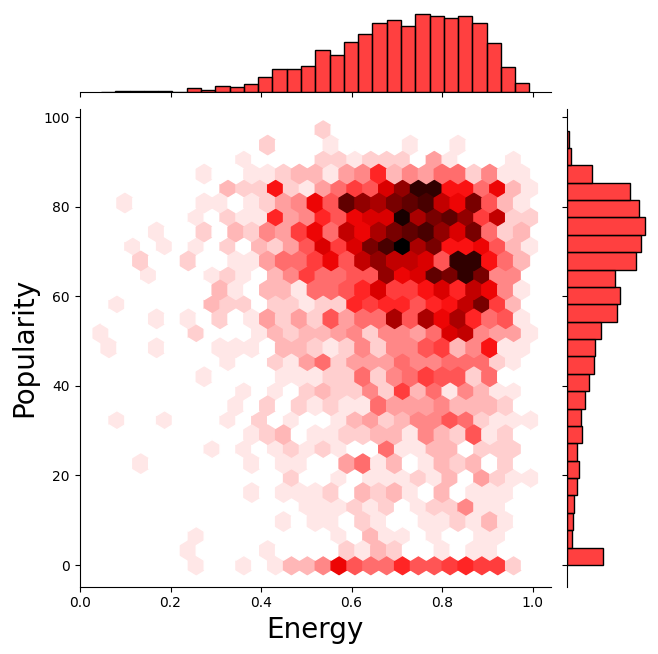

In [ ]:
x = "Energy"
y = "Popularity"

axes = seaborn.jointplot(x=data[x], y=data[y], kind="hex", color='r', height=6.5)
axes.set_axis_labels(x, y, fontsize=20)
# axes.set_ylabel(y, fontsize=20)

The data is concentrated close to 80 popularity and 0.7 energy. Meaning my music chice is often characterised with high energy songs which aare also popular.
But wait, there is a good chunck of songs that are lowere on popularity but high in energy. Interesting, I must say.

<h2>The Final Frontier</h2>

Finally, I'm going to follow an example from an article i read (link in README.md) and feed the dimension-reduced data to one-class SV< to get a sense of what the frontier of my normal taste looks like in that space, heat-map-of-the-universe-style.

t-SNE is a method of visualizing high-dimensional data in low-dimensio. Songs which are more alike will be nearer each other in the feature space, but we can't start with many dimensions. What we can do is reconstitute tthe points in 2D, attempting to preserve the pairwise distances, the notions of similarity, between songs.

<ipython-input-67-5afd774321af>:22: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  numerical_data = (numerical_data - numerical_data.mean()) / numerical_data.std()
<ipython-input-67-5afd774321af>:22: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  numerical_data = (numerical_data - numerical_data.mean()) / numerical_data.std()


using: ['Acousticness', 'Added At', 'Danceability', 'Duration (ms)', 'Energy', 'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode', 'Popularity', 'Release Date', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']


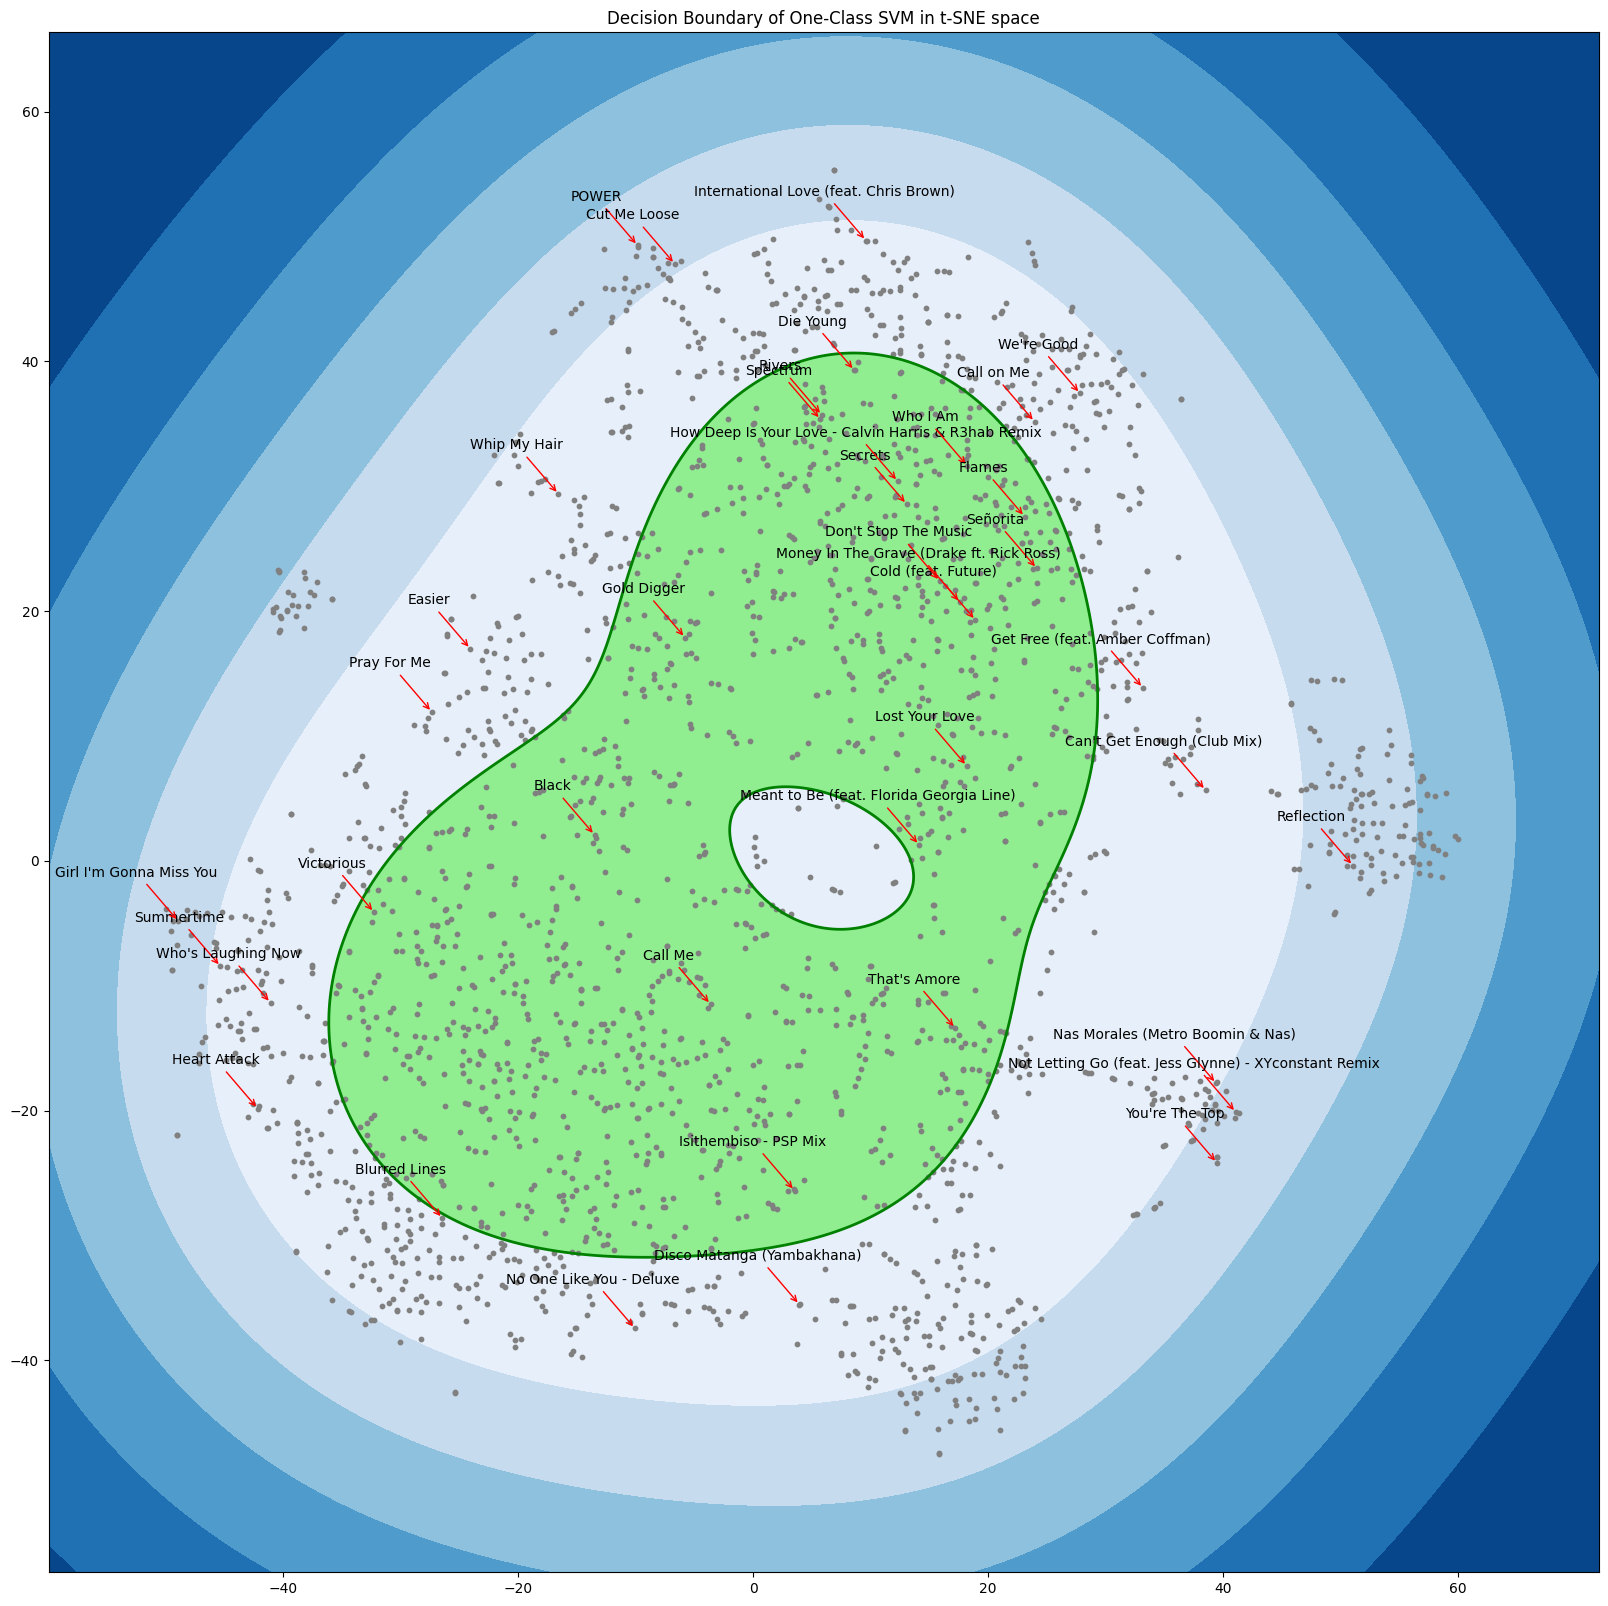

In [67]:
show_percent =2

from sklearn.manifold import TSNE
from random import random
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.impute import SimpleImputer

# Create a dataframe of only the numerical features, all normalized so embedding
# doesn't get confused by scale differences
numerical_data = data.drop(["Spotify ID", "Artist IDs", "Track Name",
                            "Album Name", "Artist Name(s)", "Added By",
                            "Genres"], axis=1)
numerical_data["Release Date"] = pd.to_numeric(
    numerical_data["Release Date"].str.slice(0, 4))

#cont_nan = numerical_data.isnull().sum()
#print("sum of nan values:"+ str(count_nan))

numerical_data = numerical_data.dropna().reset_index(drop=True)

numerical_data = (numerical_data - numerical_data.mean()) / numerical_data.std()
print("using:", list(numerical_data.columns))

# if you like, only include a subset of there, because the results with all
# is really hard to interpret
# tsme_data = numericak_data[["Popularity", "Energy", "Acousticness",
#                               "Valence", "Loudness"]]
# print("\nConsidering similarity with respect to teh following features:")
# print(tsne_data.dtypes)

# Takes a 2D data embedding and an svm trained on it and plots the decision boundary
def plotFrontier(embedded, svm, technique_name, scale):
  # get all teh points in the space and querry the svm on them
  xx, yy = np.meshgrid(np.linspace(min(embedded[:,0])*scale,
                                   max(embedded[:,0])*scale, 500),
                       np.linspace(min(embedded[:,1])*scale,
                                   max(embedded[:,1])*scale, 500))
  Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape) # positive Z means yes, negative means outliers.

  pyplot.figure(figsize=(20, 20))
  pyplot.title("Decision Boundary of One-Class SVM in "+technique_name+" space")
  pyplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=pyplot.cm.Blues_r)
  pyplot.contour(xx, yy, Z, levels=[0], linewidths=2, colors="green") # the +/- boundary
  pyplot.contourf(xx, yy, Z, levels=[0, Z.max()], colors="lightgreen")

  pyplot.scatter(embedded[:,0], embedded[:,1], s=10, c="gray")
  for i, song in data.iterrows():
    if random() < show_percent*0.01: # randomly label % of points
    # if song["Artist Name(s)"] in ["Coldplay"]:
      x, y = embedded[i]
      pyplot.annotate(song["Track Name"], (x, y), size=10,
                      xytext=(-30, 30), textcoords="offset points",
                      ha="center", va="bottom",
                      arrowprops={"arrowstyle":"->", "color":"red"})

#cont_nan = numerical_data["Added At"].isnull().sum()
#print("sum of nan values:"+ str(count_nan))

# Removing NaN values
#data.columns

# data = data.dropna('Artist Name(s)', inplace=True)
# count the nan values
#count_nan = data['Added At'].isnull().sum()
#print("nan values: " + str(count_nan))

#data = data.dropna().reset_index(drop=True)

#count_nan = data["Added At"].isnull().sum()
#print("nan values: " + str(count_nan))
#print(numerical_data.isnull().sum())
#numerical_data.dropna(inplace=True)
#print("dropped")
#print(numerical_data.isnull().sum())

# Remomve NaN values of the data_frame
imputer = SimpleImputer(strategy="median")
numerical_data_imputed = imputer.fit_transform(numerical_data)

tsne_embedded = TSNE(n_components=2).fit_transform(numerical_data_imputed)

svm_tsne = OneClassSVM(gamma="scale")
svm_tsne.fit(tsne_embedded)

plotFrontier(tsne_embedded, svm_tsne, "t-SNE", 1.2)

The pointer scatter looks really different everytime this tun, because it is Stochastic. The clusters don't necessarily have sensible interpretations, though you might be able to label a few of them. It's good to see some notionally similar pieces ending up mear each other. You can try this with a subset of these dimensions to try to make te result more interpretable.

Modifying the parameters of the SVM changes its fit significantly, so I'm not sure this is teh best model. Gamma too large just clearly fits the data. Gamma too small just makes the decision boundary a boring ellipse. Using gamma="scale" as th edocs reccomend is more a interesting middle ground, but still the SVM seems to believe that a great many of the songs I love fall outside the boundary.

I'll try a dfferent dimensionality reduction technique. The original auther uses Principle Component Analysis to feed the SVM.

% variance explained by successive PCA dimensions: [0.15728338 0.10699303]


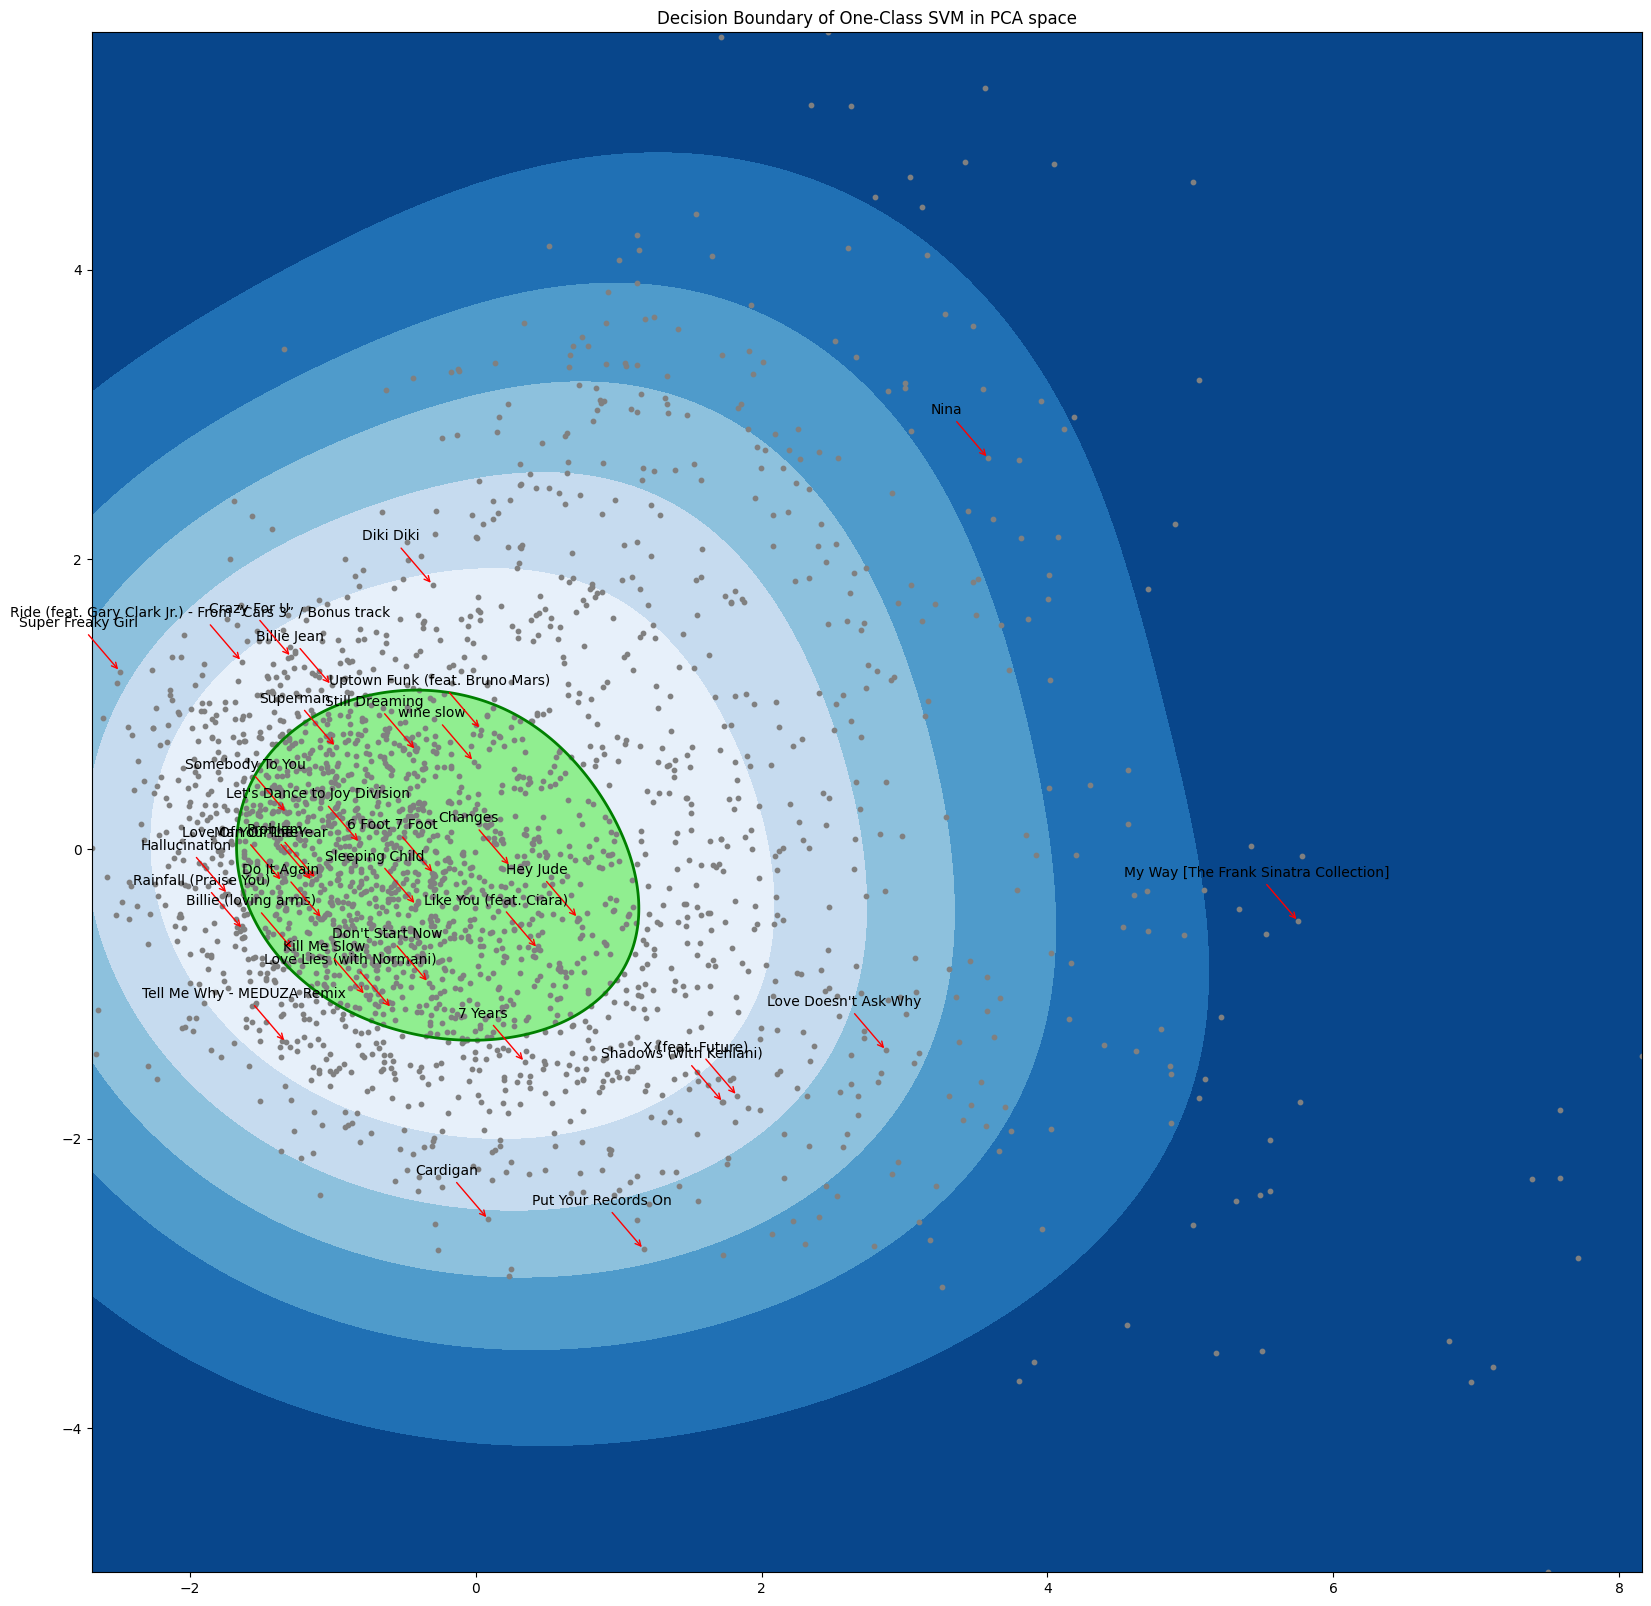

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embedded = pca.fit_transform(numerical_data_imputed)
print("% variance explained by successive PCA dimensions:",
      pca.explained_variance_ratio_)

svm_pca = OneClassSVM(gamma="scale")
svm_pca.fit(pca_embedded)

plotFrontier(pca_embedded, svm_pca, "PCA", 1)

Ideally, songs falling near the center here ,like Let's Dance to Joy Division by The Wombats, are those that most characterize my taste numerically, and the odd ones, like Frank Sinatra's My Way and Nina, fall on the outside.

So in the end my music taste is a blob that doesn't even fir the data very well. And that's the point: Like many things, it's too complicated to boil down. You can't answer the question fully. But understanding elements of the answer can aid the process of discovery, and that's valuable. It's why Spotify is such a force at recommendation. It's why Data Science is so interesting.